Produce z500 anomaly (June-Oct) maps for each WT 
 - 1 compute climatology
 - 2 break down dataset to speed up
 - 3 anomaly of WT
 - 4 plotting

In [2]:
import datetime
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_prec_12

casper_2020

NOTE: recentered projection 
 - proj = ccrs.PlateCarree(central_longitude=180)
 - da.plot.contourf(transform=ccrs.PlateCarree())
 - in dataset (ds) or data array (da)
     - ds.coords['longitude'] = xr.where(ds['longitude'] < 0, ds['longitude'] + 360, ds['longitude'])
     - ds = ds.sortby(ds.longitude)
    or
     - da.coords['longitude'] = xr.where(da['longitude'] < 0, da['longitude'] + 360, da['longitude'])
     - da = da.sortby(da.longitude)

In [3]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

# declares a recentered projection for Pacific areas
proj = ccrs.PlateCarree(central_longitude=180)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
    
def plot_S2Swt_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    # relableed WT: 0=Monsoon, 1=Normal, 2=Dry
    wt_s = ['Monsoon', 'Normal', 'Dry']
    
    fig = plt.figure(figsize=(22,12))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for nr in range(prec.shape[0]):
        for wt in range(prec.shape[1]):
            col = nr*n_wt + wt 
            #print(col, nr, wt) 
            ax_s = plt.subplot(4, 3, col+1, projection=proj)
            ax_coastlines_country(ax_s)
            ax_s.add_feature(cfeature.STATES, linestyle=':')
            #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
            im=prec[nr,wt].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                #transform=proj,
                extend='both',
                add_colorbar=False)
        
            # add contour 
            im_c = prec[nr,wt].plot.contour(ax=ax_s,transform=ccrs.PlateCarree(),levels=np.linspace(min_v, max_v, num=int(n_lev/2) + 1), colors='grey')
        
            # add lat-lon gridlines
            gl = ax_s.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
            gl.xlines = True
            #gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
            #gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'color': 'grey', 'weight': 'bold'}
        
            plt.title(region_s[nr] + ' ' +  wt_s[wt] ,fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('25 member average ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori, extend='both')
        

In [4]:
dir_ecmwf = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/'

MONTHS = [6,7,8,9,10]    # months within the NAM season

year_s = 1993
year_e = 2021

n_wt = 3

### check on data

In [5]:
flnm_test = dir_ecmwf + 'z500_201702.grib'
ds = xr.load_dataset(flnm_test, engine="cfgrib")
print('original Z500 dataset')
print(ds.dims)

z500 = ds.z.squeeze(drop=True) 
 
n_mem  = ds.dims['number']
n_step = ds.dims['step']
n_lat  = ds.dims['latitude']
n_lon  = ds.dims['longitude']
#### 12 hour output
n_fcst = n_step

latitude = ds['latitude']
longitude = ds['longitude'] 

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


original Z500 dataset
Frozen({'number': 51, 'step': 430, 'latitude': 101, 'longitude': 360})


#### 1 climatology

In [6]:
### calculate climatology of member 1-25
flnm_o = dir_ecmwf + 'z500_clim_Jun-Oct.nc'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    print('z500 mean of member 1-25 ')
    with  xr.open_dataset(flnm_o) as ds:
        z500_mean = ds.z500_daily     #(101,360)
        print(ds.dims)
else:
    is_first = True    
    for year in range(year_s, year_e+1, 1):
        # April-Aug are used for weather typing
        for month in range(4, 9, 1):  
            mon_s = str(month).zfill(2)
            
            yyyymm_s = str(year*100 + month)
            StartDay = datetime(year, month, 1,  0) 
            Time_datetime = pd.date_range(StartDay, periods = n_fcst, freq='12H')
            
            # pick MONTHS = [6,7,8,9,10]
            iTime = np.isin(Time_datetime.month, MONTHS)
            
            flnm = dir_ecmwf + 'z500_' + str(year) + mon_s + '.grib' 
            print(flnm)
            
            ds = xr.load_dataset(flnm, engine="cfgrib",  backend_kwargs={'indexpath' :''})
            # read 1-25 members , member 26-51 starts 2017    
            z500 = ds.z[:25, iTime].squeeze(drop=True).mean(dim=['number','step']) 
             
            if is_first == True:
                data_all = z500 
                is_first = False
            else:
                data_all = xr.concat([data_all, z500], dim='step')
                                         
    print(data_all.shape)
    z500_mean = data_all.mean(dim='step')
    z500_mean = z500_mean.rename('z500_daily')  
    #z500_mean.attrs('z500_S2Swt_ECMWF.ipynb') 
    print(flnm_o) 
    z500_mean.to_netcdf(path = flnm_o)  

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_clim_Jun-Oct.nc exist
z500 mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360})


#### 2 break 12 hr 1-51 member data to daily data of each member

In [7]:
year_s = 1993
year_e = 2021

for year in range(year_s, year_e+1, 1):
    #print(year)
    for month in range(4, 9, 1):
        mon_s = str(month).zfill(2)
        flnm_i = dir_ecmwf + 'z500_' + str(year) + mon_s + '.grib' 
        #print(flnm_i)
        flnm_o = dir_ecmwf + 'z500_daily_' + str(year) + mon_s + '_mem01.nc' 
        if os.path.isfile(flnm_o):
            if month == 4 and year == year_s:
                print(flnm_o, '- mem25 (-2016), -mem51(2017-)exist')
        else:
            if year < 2017:
                n_mem = 25
            else:
                n_mem = 51
        
            ds = xr.load_dataset(flnm_i, engine="cfgrib",  backend_kwargs={'indexpath' :''}) 
            
            # daily (00 and 12 hr) average
            z500_12 = ds.z[:,1::2] 
            z500_00 = ds.z[:,::2]
            z500_arr = 0.5*(z500_00.values + z500_12.values)
            
            # create a DataArray from numpy array using existed attrs, coords, dims
            z500 = xr.DataArray(z500_arr, z500_00.coords, z500_00.dims, z500_00.attrs)
            
            for mem  in range(1, n_mem+1, 1):  
                mem_s = str(mem).zfill(2)
                flnm_o = dir_ecmwf + 'z500_daily_' + str(year) + mon_s + '_mem' + mem_s +'.nc' 
                print(flnm_o)
                z500_daily = z500[mem-1,:,:,:]
                z500_daily = z500_daily.rename('z500_daily')
                z500_daily = z500_daily.rename({'step':'forecast_time'})
                
                z500_daily.to_netcdf(path = flnm_o)
                

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_daily_199304_mem01.nc - mem25 (-2016), -mem51(2017-)exist


#### 3 z500 anomalies of WTs
 - 3.1 annual

In [8]:
# Climatology of ensemble anomaly is slow, 
# so I calculated member by member in next section
# James and I decided to use anamaly calculation use climatology of member mean

year_s = 1993
year_e = 2021
#year_e = year_s

n_wt = 3
n_mem = 25

region_s = ['Arizona_East', 'Arizona_West', 'NM_North', 'NM_South'] 
#region_s = ['Arizona_East', 'Arizona_West']
n_region = len(region_s)

with  xr.open_dataset(dir_ecmwf + 'z500_clim_Jun-Oct.nc') as ds_cli:
    z500_cli = ds_cli.z500_daily
     
z500_3d = np.zeros((n_wt, z500_cli.shape[0], z500_cli.shape[1]))
count_1d = np.zeros((n_wt))

for region in region_s:
    for mem in range(1, n_mem+1, 1): 
        z500_3d = np.zeros((n_wt, z500_cli.shape[0], z500_cli.shape[1]))
        count_1d = np.zeros((n_wt)) 
        mem_s = str(mem).zfill(2) 
        flnm_o = dir_wt + region + '/z500_ano_mem' + mem_s + '_' + region + '.nc'
        #print(flnm_o)
     
        if os.path.isfile(flnm_o):
            print(flnm_o, 'exist')
        else:
            
            print('mem', mem, 'region', region)
            
            if mem < 26:
                year_s = 1993
            else:
                year_s = 2017
            
            for year in range(year_s, year_e+1, 1):   
                for month in range(4, 9, 1):
                    month_s = str(month).zfill(2)

                    # read WT file
                    flnm_wt = dir_wt + region + '/' + region + '-WTs_' + str(year) + month_s + '_'+ mem_s +'.cla'               
                    wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
                    #print(flnm_wt)
                    #print(wts.wt.unique())
                    flnm = dir_ecmwf + 'z500_daily_' + str(year) + month_s + '_mem' + mem_s + '.nc'
                    yyyymm_s = str(year*100 + month)
                    StartDay = datetime(year, month, 1,  0) 
                    Time_datetime = pd.date_range(StartDay, periods = n_fcst/2, freq='D')
                    #print(Time_datetime)
                         
                    with  xr.open_dataset(flnm) as ds:
                        z500 = ds.z500_daily
                            
                        for nw in wts.wt.unique(): 
                            wts_g = wts.groupby(['wt'])
                            g_ind = wts_g.get_group(nw).index
                            yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                            yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                            
                            # pick WT date
                            iTime = np.isin(Time_datetime, yyyymmdd_wt)
                            #print(Time_datetime[iTime])
                            z500_np = z500[iTime,:,:].values                           
                            z500_3d[nw] = z500_3d[nw] + z500_np.sum(axis=0)   
                            
                            count_1d[nw] = count_1d[nw] + z500_np.shape[0]
                            
            for nw in range(n_wt):                     
                z500_3d[nw] = z500_3d[nw]/count_1d[nw]
                z500_3d[nw] = (z500_3d[nw] - z500_cli)/z500_cli  
     
            z500_xr = xr.DataArray(z500_3d, 
                    coords={'latitude': z500_cli.latitude, 'longitude': z500_cli.longitude, 'wt':range(n_wt)},
                    dims=["wt", "latitude", "longitude"])
            z500_xr = z500_xr.rename('z500_ano') 
            print(flnm_o)
            z500_xr.to_netcdf(path = flnm_o) 
        

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem01_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem02_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem03_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem04_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem05_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem06_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem07_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem08_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_ano_mem09_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_S2S/Arizona_East/z500_an

#### 4 Plotting

In [9]:
z500_4d = np.zeros((n_region, n_wt, z500_cli.shape[0], z500_cli.shape[1]))

for mem in range(1, n_mem+1):
    mem_s = str(mem).zfill(2) 
    nr = 0
    for region in region_s:
        mem_s = str(mem).zfill(2) 
        flnm = dir_wt + region + '/z500_ano_mem' + mem_s  + '_' + region + '.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            # proj = ccrs.PlateCarree(central_longitude=180)
            # longitude from [-180, 180] -> [0,360]
            #ds.coords['longitude'] = xr.where(ds['longitude'] < 0, ds['longitude'] + 360, ds['longitude'])
            #ds = ds.sortby(ds.longitude)
            if mem == 1: 
                z500_4d[nr] = ds.z500_ano
            else:
                z500_4d[nr] = z500_4d[nr] + ds.z500_ano
        nr = nr + 1
z500_xr = xr.DataArray(z500_4d/n_mem, 
                coords={'latitude': z500_cli.latitude, 'longitude': z500_cli.longitude, 'wt':range(n_wt), 'region':range(n_region)},
                dims=["region", "wt", "latitude", "longitude"])

In [10]:
print('min:', z500_xr.min(), 'max:', z500_xr.max());

min: <xarray.DataArray ()>
array(-0.01970171) max: <xarray.DataArray ()>
array(0.01701451)


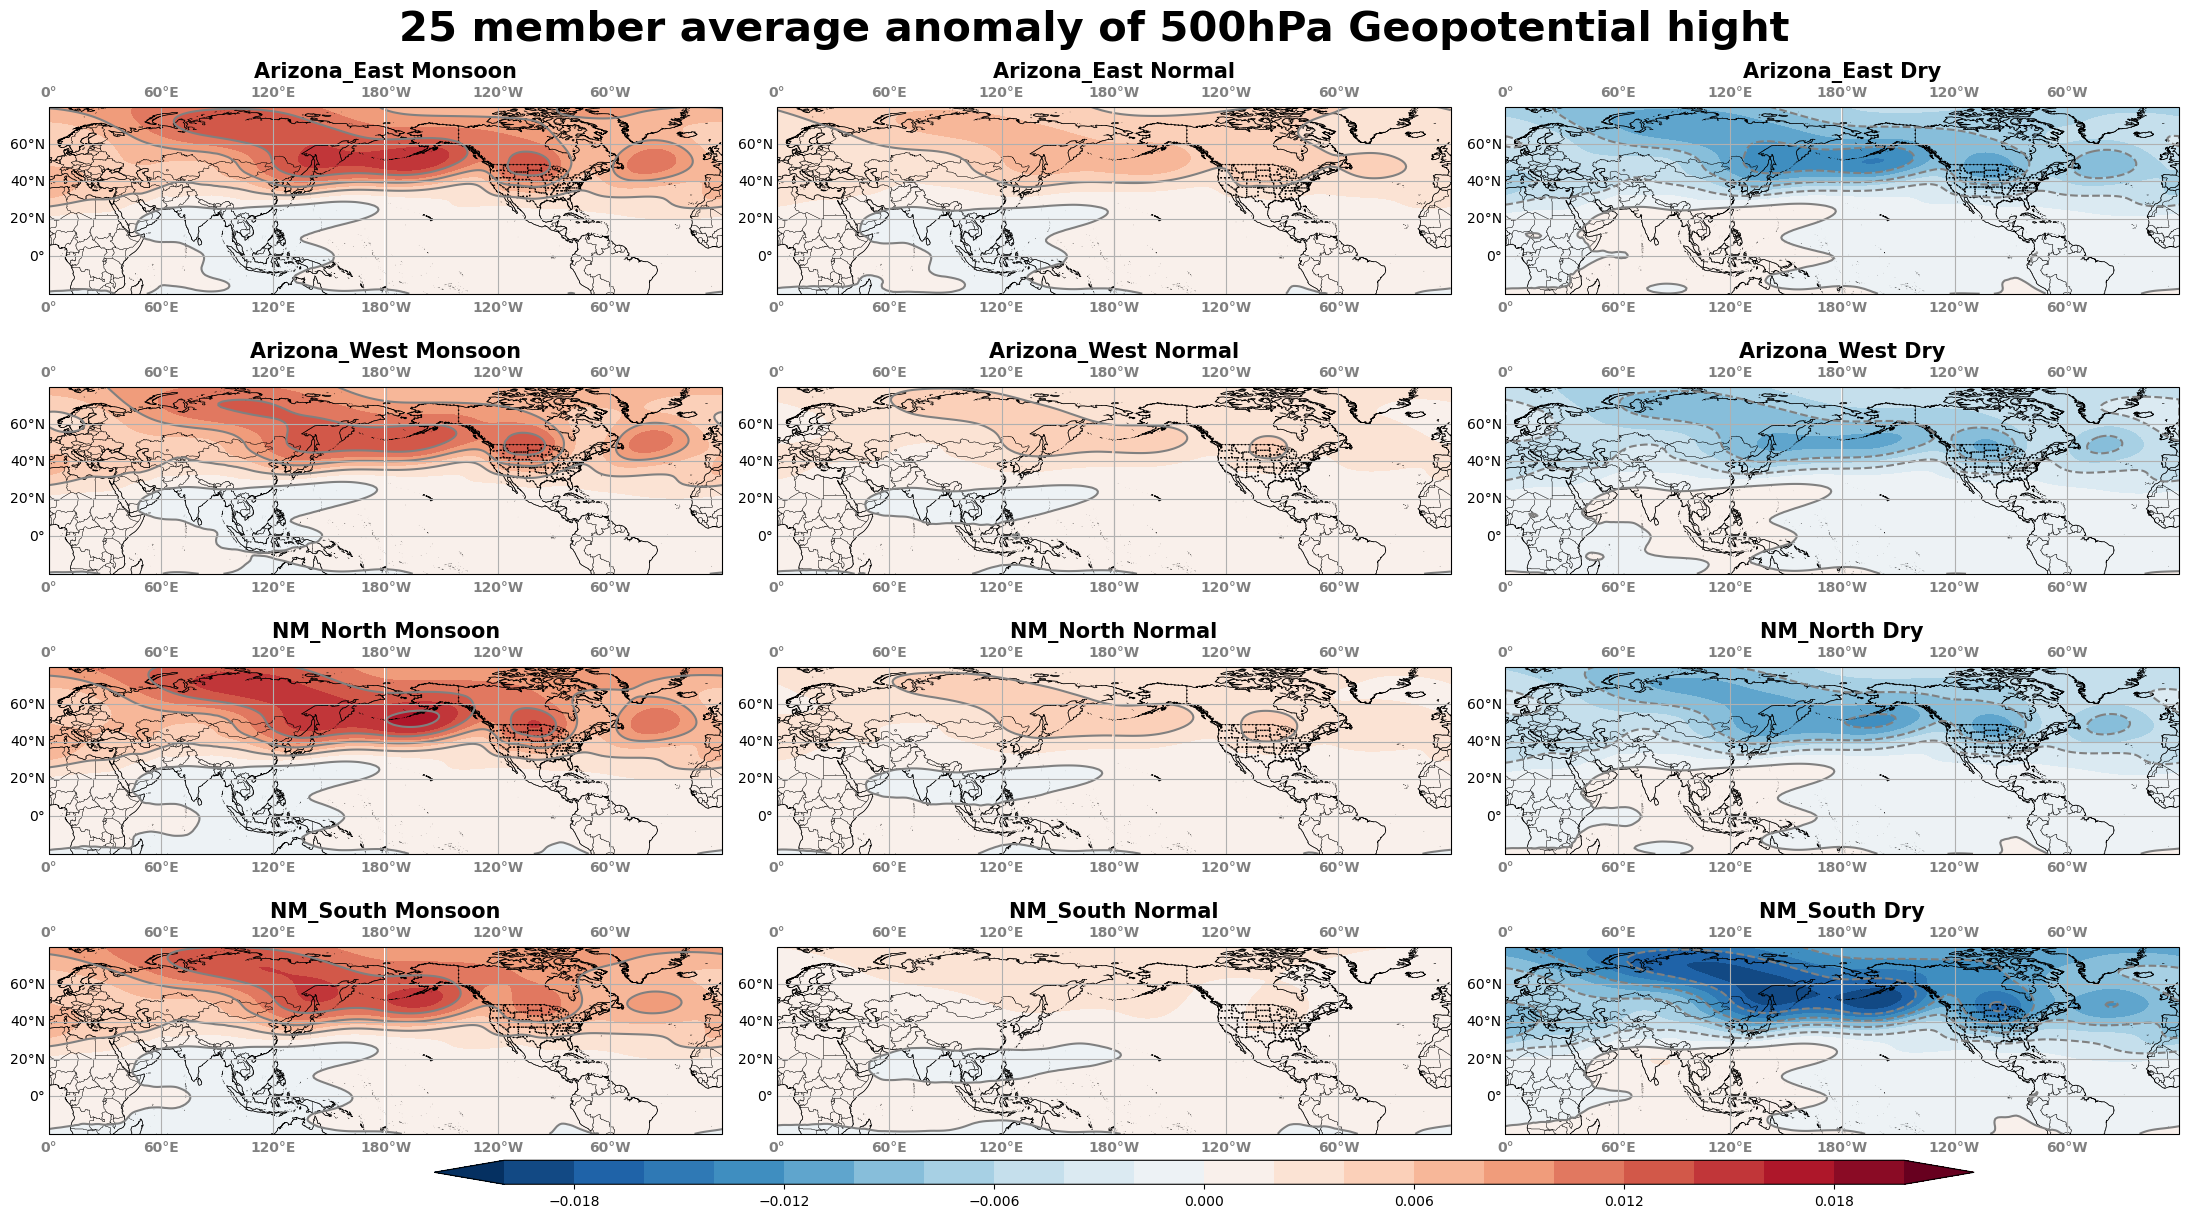

In [11]:
plot_S2Swt_12(z500_xr, -0.02, 0.02, 21, 'RdBu_r', 'horizontal', 'anomaly of 500hPa Geopotential hight')